In [1]:
import sys
import os
import math
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve, accuracy_score
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

from j_utils import munging as mg
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import shap
shap.initjs()

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')
pd.options.display.max_columns = 999

In [2]:
check_cols = ['maturity_time', 'maturity_paid', 'maturity_time_stat_adj', 'maturity_paid_stat_adj',
              'target_loose', 'target_strict', 'loan_status', 'issue_d', 'end_d', 'id']
good_statuses = ['paid', 'current']

# Exploration

In [4]:
eval_loan_info = pd.read_feather(os.path.join(dpath,'eval_loan_info.fth'))
# scaled_pmt_hist = pd.read_feather(os.path.join(dpath,'scaled_pmt_hist.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath,'base_loan_info.fth'))
# str_loan_info = pd.read_feather(os.path.join(dpath,'str_loan_info.fth'))

In [5]:
# add in issue_d
base_loan_info['issue_d'] = eval_loan_info['issue_d']

In [6]:
# get loans that are >= .95 maturity time, maturity paid, or status is in defaulted, charged_off, paid
trainable_loan_ids = eval_loan_info[(eval_loan_info['maturity_time_stat_adj'] >= .95) |
                               (eval_loan_info['maturity_paid_stat_adj'] >= .95) |
                               (eval_loan_info['loan_status'].isin(['paid', 'charged_off', 'defaulted']))
                              ]['id'].values

## fix step to data

In [ ]:
# quick fix to eval_loan_info, future times see if this cell needs to be run
eval_loan_info['maturity_time_stat_adj'] = np.where(
    (eval_loan_info['maturity_time_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'paid'), 1,
         np.where(
             (eval_loan_info['maturity_time_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'current'), 
 eval_loan_info['maturity_time'], eval_loan_info['maturity_time_stat_adj']))

eval_loan_info['maturity_paid_stat_adj'] = np.where(
    (eval_loan_info['maturity_paid_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'paid'), 1,
         np.where(
             (eval_loan_info['maturity_paid_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'current'), 
 eval_loan_info['maturity_paid'], eval_loan_info['maturity_paid_stat_adj']))

In [ ]:
eval_loan_info.to_feather(os.path.join(dpath,'eval_loan_info.fth'))

In [ ]:
(eval_loan_info['maturity_paid_stat_adj'] < 0).sum()

In [ ]:
(eval_loan_info['maturity_time_stat_adj'] < 0).sum()

## continue

In [ ]:
trainable_loans = eval_loan_info[eval_loan_info['id'].isin(trainable_loan_ids)]
untrainable_loans = eval_loan_info[~eval_loan_info['id'].isin(trainable_loan_ids)]

In [ ]:
# make sure untrainable loans actually look untrainable
untrainable_loans.groupby('loan_status',).apply(lambda x: x.sample(min(len(x), 3)))

In [ ]:
trainable_eli = trainable_loans
trainable_li = base_loan_info[base_loan_info['id'].isin(trainable_loan_ids)]
print(trainable_eli.shape, trainable_li.shape)

In [ ]:
df = trainable_li.merge(trainable_eli[['target_strict', 'id', 'loan_status']], on='id')

## split into time_series_cv splits

In [ ]:
df.drop('loan_status', axis=1, inplace=True)

In [ ]:
# get categorical feature indices for catboost
obj_cols = df.select_dtypes(['object', 'datetime']).columns
categorical_features_indices = [df.columns.get_loc(col) for col in obj_cols]
obj_cols

In [ ]:
# map dates to numbers
date_cols = df.select_dtypes('datetime').columns
for col in date_cols:
    mapper = {}
    for i, val in enumerate(sorted(df[col].unique())):
        mapper[val] = i
    df[col] = df[col].replace(mapper)
    if col == 'issue_d':
        issue_d_mapper = mapper

In [ ]:
pd.Series(issue_d_mapper)

In [ ]:
# split out the test set, say the last 12 months
test = df[df['issue_d'] >= (df['issue_d'].max() - 12)]
train = df[df['issue_d'] < (df['issue_d'].max() - 12)]

In [ ]:
print(test.shape)
test.head()

In [ ]:
print(train.shape)
train.head()

In [ ]:
# see if theres any difference in pct defaulted from train and test
print(test['target_strict'].sum()/len(test), train['target_strict'].sum()/len(train))

# a slightly higher percentage of defaulting loans. This makes sense due to defaulting loans finishing faster, thus being able to be included in trainable loans, compared to ongoing loans that won't default but still need to reach term

In [ ]:
# basic split for now, probably some leakage (using some loans issued in same month for train and validation. Go with this for now, come back and make better custom splits later)
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
for train_index, test_index in tscv.split(train):
    print("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
y = train['target_strict']
train.drop('target_strict', axis=1, inplace=True)
X = train

X_train = X.iloc[train_index,:]
y_train = y.iloc[train_index]

X_valid = X.iloc[test_index,:]
y_valid = y.iloc[test_index]

y_test = test['target_strict']
test.drop('target_strict', axis=1, inplace=True)
X_test = test

In [ ]:
# make a custom loss function that puts more emphasis on missclasifying defaulting
class CustomObjective(object):
    '''
    for derivations
    https://stats.stackexchange.com/questions/231220/how-to-compute-the-gradient-and-hessian-of-logarithmic-loss-question-is-based
    https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
    https://socratic.org/questions/what-is-the-derivative-of-e-x-8
    '''
    
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            # der 1 and 2 have negative in front because they are gradient?
            der1 = 4*(-1)*(p - 1) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

## model and eval

In [ ]:
params = {
    'iterations': 1000,
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
    'has_time': True,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
    'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_valid, y_valid),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

In [ ]:
pred_prob = model.predict_proba(X_test)

In [ ]:
y_test.shape

In [ ]:
pred_prob.shape

In [ ]:
# eval_metric = Logloss
p,r,_ = precision_recall_curve(y_test, pred_prob[:,1])
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax1.plot(r, p)
plt.show()

In [ ]:
# eval_metric = Recall
p,r,_ = precision_recall_curve(y_test, pred_prob[:,1])
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax1.plot(r, p)
plt.show()

In [ ]:
# eval_metric = AUC
p,r,_ = precision_recall_curve(y_test, pred_prob[:,1])
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax1.plot(r, p)
plt.show()

## hyperopt

In [ ]:
# what matters:
# according to P/R-plots above, best eval_metric is probably Logloss
#

In [ ]:
import hyperopt

def hyperopt_objective(params_holder):
    '''pick 500 loans, trying to maximize return'''
    to_store = {}
    
#     # corrections to params
#     params_holder['cb']['one_hot_max_size'] = int(params_holder['cb']['one_hot_max_size'])
    params = params_holder['cb']
    cv_params = params_holder['cv']
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=categorical_features_indices,
              eval_set=(X_valid, y_valid), logging_level='Silent', plot=True)
    
    # get predictions on test
    pred_probs = model.predict_proba(X_test)[:,1]
    pred_ser = pd.Series(data=pred_probs, index=X_test['id'].values)
    pred_ser.sort_values(inplace=True) #ascending
    
    # get top 200 at 7% discount rate
    returns = eval_loan_info[eval_loan_info['id'].isin(pred_ser.index[:200])]
    mean_returns = returns['0.07'].mean()
    
    
    # store things
    to_store['params'] = params_holder
    to_store['pred_ser'] = pred_ser
    to_store['mean_returns'] = mean_returns
    
    if stats_dict.keys():
        t = max(stats_dict.keys())+1
        stats_dict[t] = to_store
    else:
        stats_dict[0] = to_store
#     cv_data = cv(
#         Pool(X, y, cat_features=categorical_features_indices),
#         model.get_params(),
#         **cv_params
#     )
#     best_accuracy = np.max(cv_data['test-{0}-mean'.format()])
    
    return 1 - mean_returns # as hyperopt minimises

In [ ]:
params_space = {'cb': {
    # Common Params _____________
    'eval_metric': 'Logloss',
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'bootstrap_type': hyperopt.hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'Poisson']),
    'random_strength': hyperopt.hp.uniform('random_strength', 1e-1, 1e1),
    'use_best_model': True,
    'min_data_in_leaf': hyperopt.hp.uniform('min_data_in_leaf', 1, 1e2),
#     'one_hot_max_size': hyperopt.hp.uniform('one_hot_max_size', 2, 50),
    'has_time': hyperopt.hp.choice('has_time', [True, False]),
    'class_weights': hyperopt.hp.choice('class_weights', [None, [1, 4]]),
    'boosting_type': hyperopt.hp.choice('boosting_type', ['Ordered', 'Plain']),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
    'boosting_type': 'Ordered',
#     'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
    'od_type': 'Iter',
    'od_wait': 300,
}, 'cv':
    {'type': 'TimeSeries',
     'shuffle': hyperopt.hp.choice('shuffle', [True, False])
     }
}

In [ ]:
from numpy.random import RandomState

stats_dict = {}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

In [ ]:
example_params = {'cb': {'eval_metric': 'Logloss',
#   'learning_rate': <hyperopt.pyll.base.Apply at 0x7f8400e66978>,
#   'l2_leaf_reg': <hyperopt.pyll.base.Apply at 0x7f8400e66b00>,
#   'bootstrap_type': <hyperopt.pyll.base.Apply at 0x7f8400e66c18>,
#   'random_strength': <hyperopt.pyll.base.Apply at 0x7f8400e66e48>,
#   'use_best_model': True,
#   'min_data_in_leaf': <hyperopt.pyll.base.Apply at 0x7f8400e66f98>,
#   'one_hot_max_size': <hyperopt.pyll.base.Apply at 0x7f8400e5d128>,
#   'has_time': <hyperopt.pyll.base.Apply at 0x7f8400e5d240>,
#   'class_weights': <hyperopt.pyll.base.Apply at 0x7f8400e5d3c8>,
  'boosting_type': 'Ordered',
  'random_seed': 42,
  'logging_level': 'Silent',
  'task_type': 'GPU',
  'od_type': 'Iter',
  'od_wait': 300},
 'cv': {'type': 'TimeSeries',
#   'shuffle': <hyperopt.pyll.base.Apply at 0x7f8400e5d518>
       }}

hyperopt_objective(example_params)

# Actual training

In [3]:
train_loan_info = pd.read_feather(os.path.join(dpath, 'train_loan_info.fth'))
train_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))

In [4]:
# the regressor (return predictor) seems to rely heavily on time via id or is_null
# perhaps remove loans that have that column null?

## Basic training, cross validation and basic scorer

In [30]:
# time series cross validation for catboost

tscv = TimeSeriesSplit(n_splits=5)
results = []
for train_index, test_index in tscv.split(train_loan_info):
#     print("TRAIN:", len(train_index), "TEST:", len(test_index))
    # set up datasets
    X_train, y_train, X_valid, y_valid = train_loan_info.iloc[train_index,:], train_eval_loan_info.iloc[train_index]['target_strict'], train_loan_info.iloc[test_index,:], train_eval_loan_info.iloc[test_index]['target_strict']
    
    # catboost cannot use dates, use fastai style processing
    X_train, all_train_colnames, max_dict, min_dict, new_null_colnames, fill_dict, cats_dict, norm_dict = mg.train_proc(X_train)
    X_valid = mg.val_test_proc(X_valid, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict)
    
    # get categorical feature indices for catboost
    obj_cols = X_train.select_dtypes(['object', 'datetime']).columns
    categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]
    
#     import ipdb; ipdb.set_trace()
    
    model = CatBoostClassifier(**params)
    model.fit(
        X_train,
        y_train,
        cat_features=categorical_features_indices,
        eval_set=(
            X_valid,
            y_valid,
        ),
    #     logging_level='Verbose',
        plot=True
    )
    results.append((train_index, test_index, (model, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict)))

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_inq_last_6_mths', 'revol_bal_joint', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_earliest_cr_line', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'sec_app_mort_acc', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'is_inc_v_joint', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/justin/projects/j_utils/munging.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/index

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_inq_last_6_mths', 'revol_bal_joint', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_earliest_cr_line', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'sec_app_mort_acc', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'is_inc_v_joint', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_inq_last_6_mths', 'revol_bal_joint', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_earliest_cr_line', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'sec_app_mort_acc', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'is_inc_v_joint', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_inq_last_6_mths', 'revol_bal_joint', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_earliest_cr_line', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'sec_app_mort_acc', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'is_inc_v_joint', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col]-mean)/std
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

dropping the following cols: 
['earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'sec_app_chargeoff_within_12_mths', 'term', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


/home/justin/projects/j_utils/munging.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
/home/justin/projects/j_utils/munging.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/projects/j_utils/munging.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
def plot_pr(tup, df, df_y):
    _, y_ind, model_stuff = tup
    model, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict = model_stuff
    X_test, y_test = df.iloc[y_ind,:], df_y.iloc[y_ind]['target_strict']
    
    X_test = mg.val_test_proc(X_test, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict)
    
    pred_prob = model.predict_proba(X_test)[:,1]
    p,r,_ = precision_recall_curve(y_test, pred_prob)
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')
    ax1.plot(r, p)
    plt.show()

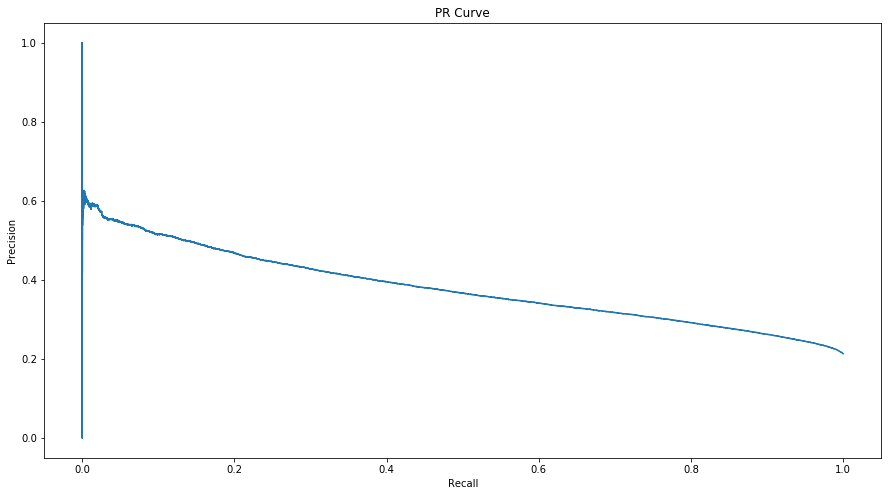

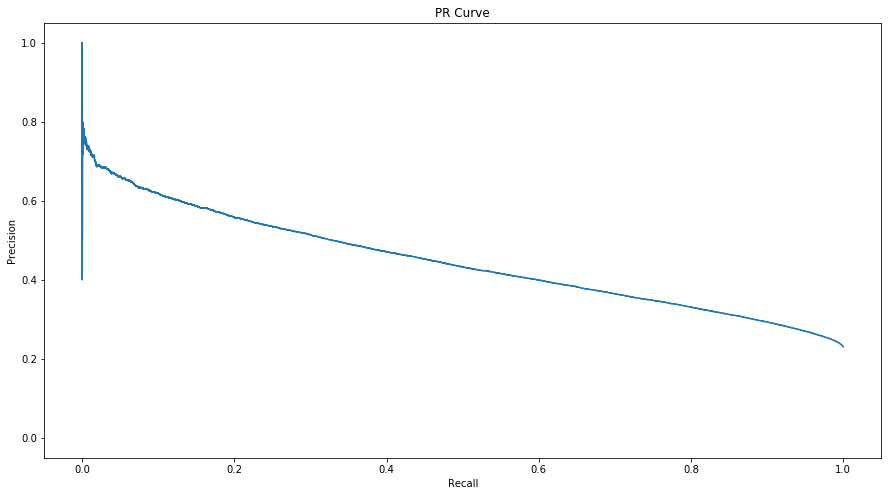

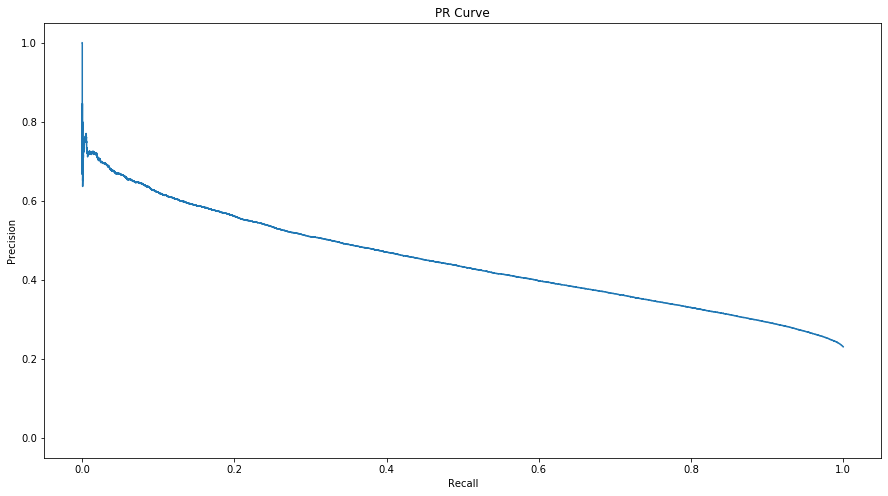

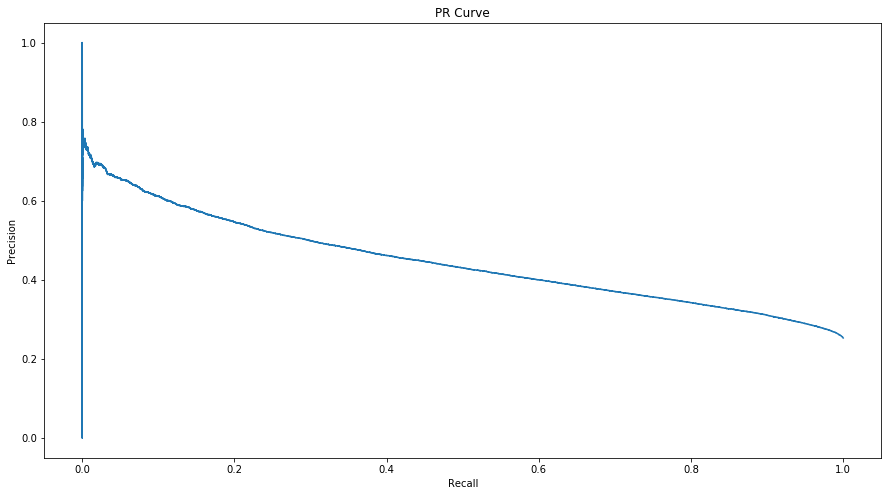

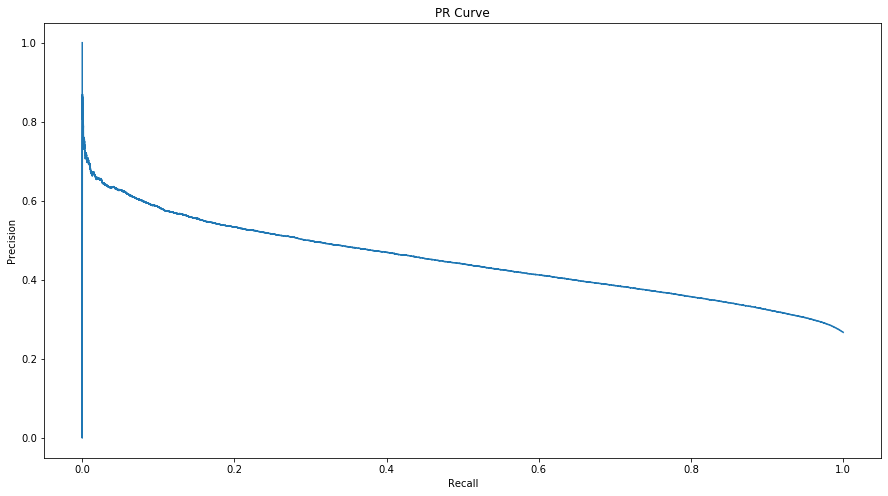

In [32]:
# check plots
for res in results:
    plot_pr(res, train_loan_info, train_eval_loan_info)

# Drop loan_id as being the most predictive, because I don't think there's a cler trend as to which affect it will have on returns and default going forward

## catboost_clf, full basic train

In [5]:
# basic params
params = {
    'iterations': 5000,
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
#     'has_time': True,
    'eval_metric': 'AUC',#'Recall',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_loan_info, train_eval_loan_info['target_strict'], test_size = .05, random_state=42)

X_train = X_train.drop('id', axis=1)
X_valid = X_valid.drop('id', axis=1)

# catboost cannot use dates, use fastai style processing
X_train, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, new_null_colnames, norm_dict = mg.train_proc(X_train, isnull=True)#new_null_colnames,
X_valid = mg.val_test_proc(X_valid, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict)

# get categorical feature indices for catboost
obj_cols = X_train.select_dtypes(['object', 'datetime']).columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

dropping the following cols: 
['sec_app_earliest_cr_lineDay', 'sec_app_earliest_cr_lineIs_month_end', 'sec_app_earliest_cr_lineIs_quarter_end', 'sec_app_earliest_cr_lineIs_year_end', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'sec_app_earliest_cr_lineIs_month_start', 'sec_app_earliest_cr_lineIs_quarter_start', 'sec_app_earliest_cr_lineIs_year_start', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


In [7]:
model = CatBoostClassifier(**params)
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(
        X_valid,
        y_valid,
    ),
#     logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [8]:
explainer = shap.KernelExplainer(model.predict, X_train.head(10000))
shap_values = model.get_feature_importance(Pool(X_train.head(10000), y_train.head(10000)), type='ShapValues', )

Using 10000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [9]:
# visualize shap for X_train.iloc[0]
shap.force_plot(explainer.expected_value, shap_values[0, :-1], feature_names=X_train.columns)#, out_names=list(y_train.unique()))

In [10]:
# visualize shap for X_train.iloc[0]
# shap.force_plot(explainer.expected_value, shap_values[:,:-1], feature_names=X_train.columns)#, out_names=list(y_train.unique()))

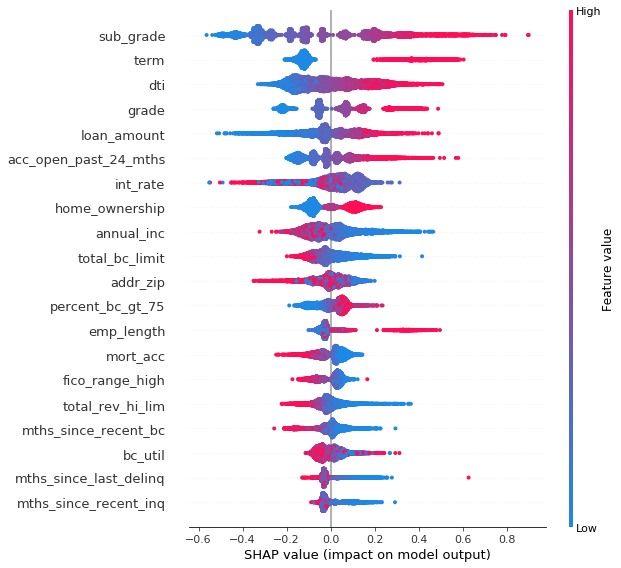

In [11]:
shap.summary_plot(shap_values[:, :-1], features=X_train.head(10000))

In [12]:
# check the most interesting important features

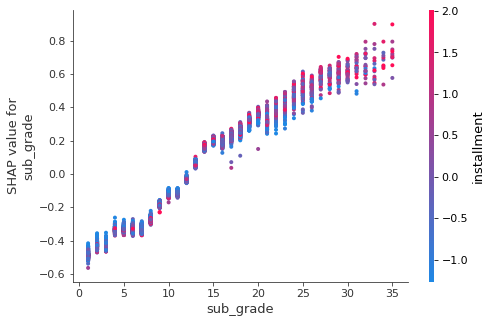

In [13]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("sub_grade", shap_values[:,:-1], X_train.head(10000), )
# high subgrade with high interest rate unsurprisingly means higher probability (log odds?) of deafult

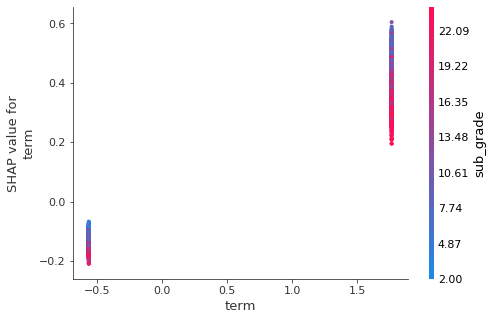

In [14]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("term", shap_values[:,:-1], X_train.head(10000), )
# having a high subgrade actually makes you less likley to default across both terms?
# or maybe this more shows LC's mismatch in characterizing risk?

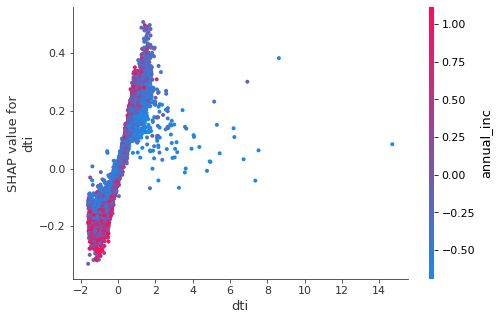

In [15]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("dti", shap_values[:,:-1], X_train.head(10000), )
# sort of looks like if you have high dti + high income, your probability of default goes up
# if you have low dti and high income, your probability of default goes down

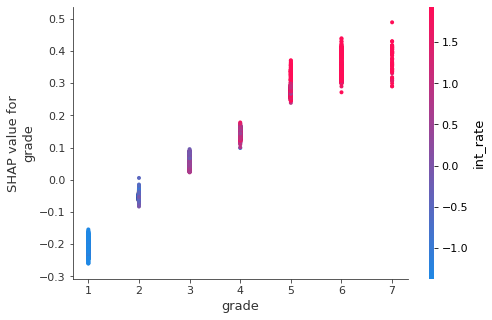

In [16]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("grade", shap_values[:,:-1], X_train.head(10000), )
# basically looks the same as by subgrade

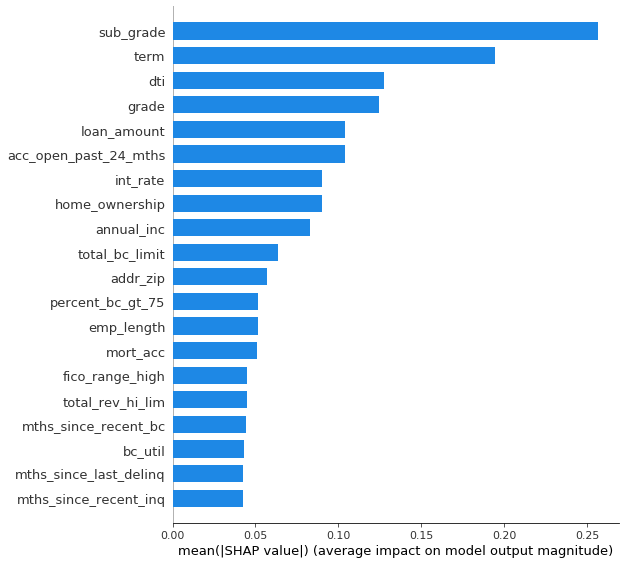

In [17]:
shap.summary_plot(shap_values[:,:-1], X_train.head(10000), plot_type="bar")

In [18]:
# temporarily rename variable separate to check with regressor
all_train_colnames_clf = all_train_colnames
max_dict_clf = max_dict
min_dict_clf = min_dict
new_null_colnames_clf = new_null_colnames
fill_dict_clf = fill_dict
cats_dict_clf = cats_dict
norm_dict_clf = norm_dict

In [113]:
# save necessities for scoring
from joblib import dump
mpath = os.path.join(ppath, 'models', 'catboost_clf')
model.save_model(os.path.join(mpath, 'catboost_clf.cb'))
# save necessities for scoring
dump(all_train_colnames.to_list(), os.path.join(mpath,'all_train_colnames.joblib'))
dump(max_dict, os.path.join(mpath,'max_dict.joblib'))
dump(min_dict, os.path.join(mpath,'min_dict.joblib'))
dump(new_null_colnames, os.path.join(mpath,'new_null_colnames.joblib'))
dump(fill_dict, os.path.join(mpath,'fill_dict.joblib'))
dump(cats_dict, os.path.join(mpath,'cats_dict.joblib'))
dump(norm_dict, os.path.join(mpath,'norm_dict.joblib'))

['/home/justin/projects/lendingclub/models/catboost_clf/norm_dict.joblib']

## catboost_regr

In [19]:
# catboost_clf works well, but the problem is it chooses A loans heavily
# which makes sense since it picks loans with lowest probability of default
# However, this actually lowers returns. Try regressor trained on returns
# to pick more aggressively

In [20]:
# basic params for regressor
params = {
    'iterations': 50000,
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
#     'has_time': True,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',#'Recall',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['MAE', 'RMSE', 'MAPE', 'Quantile'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(train_loan_info, train_eval_loan_info['0.07'], test_size = .05, random_state=42)

X_train = X_train.drop('id', axis=1)
X_valid = X_valid.drop('id', axis=1)

# catboost cannot use dates, use fastai style processing
X_train, all_train_colnames, max_dict, min_dict,  fill_dict, cats_dict, norm_dict = mg.train_proc(X_train, isnull=False)#new_null_colnames,
X_valid = mg.val_test_proc(X_valid, all_train_colnames, max_dict, min_dict, fill_dict, cats_dict, norm_dict, isnull=False)

# get categorical feature indices for catboost
obj_cols = X_train.select_dtypes(['object', 'datetime']).columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

dropping the following cols: 
['sec_app_earliest_cr_lineDay', 'sec_app_earliest_cr_lineIs_month_end', 'sec_app_earliest_cr_lineIs_quarter_end', 'sec_app_earliest_cr_lineIs_year_end', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['initial_list_status', 'application_type', 'term', 'sec_app_earliest_cr_lineIs_month_start', 'sec_app_earliest_cr_lineIs_quarter_start', 'sec_app_earliest_cr_lineIs_year_start', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


In [ ]:
model = CatBoostRegressor(**params)
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(
        X_valid,
        y_valid,
    ),
#     logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [120]:
# shap

In [121]:
explainer = shap.KernelExplainer(model.predict, X_train.head(10000))
shap_values = model.get_feature_importance(Pool(X_train.head(10000), y_train.head(10000)), type='ShapValues', )

Using 10000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [122]:
# visualize shap for X_train.iloc[0]
shap.force_plot(explainer.expected_value, shap_values[0, :-1], feature_names=X_train.columns)#, out_names=list(y_train.unique()))

In [123]:
# visualize shap for X_train.iloc[0]
# shap.force_plot(explainer.expected_value, shap_values[:,:-1], feature_names=X_train.columns)#, out_names=list(y_train.unique()))

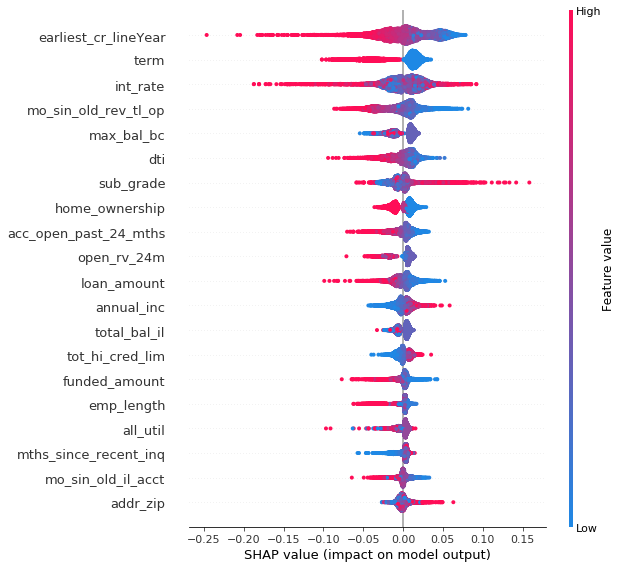

In [124]:
shap.summary_plot(shap_values[:, :-1], features=X_train.head(10000))

In [125]:
# check the most interesting important features

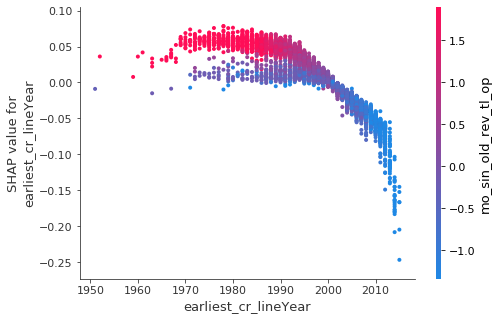

In [126]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("earliest_cr_lineYear", shap_values[:,:-1], X_train.head(10000), )
# the older/earlier the credit line, the better for higher returns
# largest effect with months since old revolving tradeline opened
# we see that having earliest credit line < 2000 and having your oldest trade line opened a long time ago
# those contribute to higher returns for that loan. If earliest credit line was > 2000, having a very old
# months since old revolving trade line actually hurts returns. 
# Another thing could be that if you had a credit line opened < 2000 but your first trade line is new
# that could be a sign of weaker financial state/some financial trouble may be causing you to tap into new
# ways to borrow money

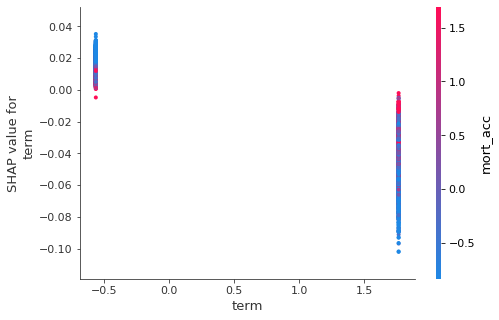

In [127]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("term", shap_values[:,:-1], X_train.head(10000), )
# total_balance_il_isnull is actually a marker of older loan or newer loan, as lendingclub
# didn't collect the data from applicants in the past

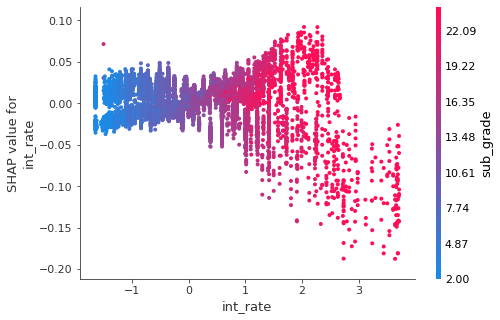

In [128]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("int_rate", shap_values[:,:-1], X_train.head(10000), )
# total_balance_il_isnull is actually a marker of older loan or newer loan, as lendingclub
# didn't collect the data from applicants in the past

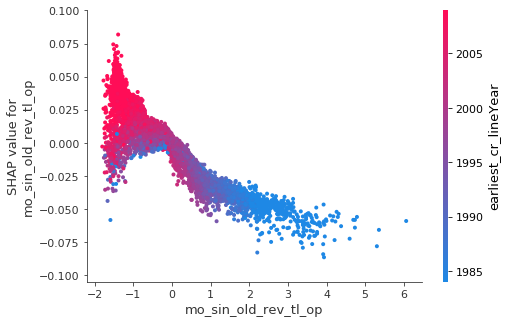

In [129]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("mo_sin_old_rev_tl_op", shap_values[:,:-1], X_train.head(10000), )
# total_balance_il_isnull is actually a marker of older loan or newer loan, as lendingclub
# didn't collect the data from applicants in the past

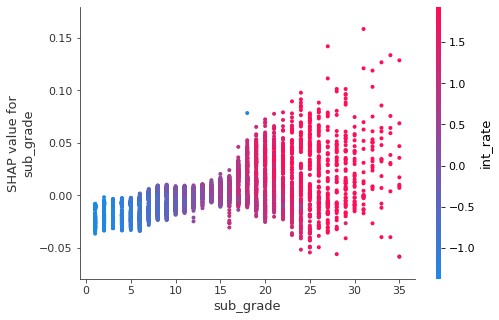

In [130]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("sub_grade", shap_values[:,:-1], X_train.head(10000), )
# total_balance_il_isnull is actually a marker of older loan or newer loan, as lendingclub
# didn't collect the data from applicants in the past

In [131]:
# all the is_null are time indicators

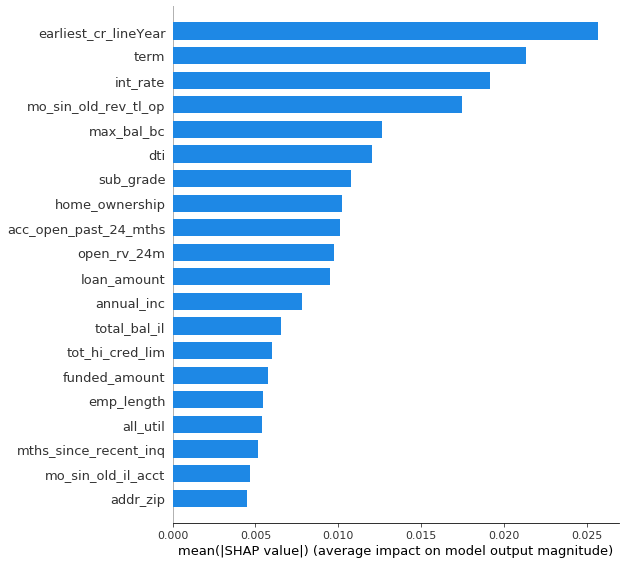

In [132]:
shap.summary_plot(shap_values[:,:-1], X_train.head(10000), plot_type="bar")

In [133]:
# temporarily rename variable separate to check with classifier
all_train_colnames_regr = all_train_colnames
max_dict_regr = max_dict
min_dict_regr = min_dict
new_null_colnames_regr = new_null_colnames
fill_dict_regr = fill_dict
cats_dict_regr = cats_dict
norm_dict_regr = norm_dict

# compare the two variables necessary for data processing

In [134]:
# all_train_colnames not the same
# max_dict is the same
# min_dict is the same
# new_null_colnames is the same
# fill_dict not the same BUT FILL VALUE IS SAME. CAN USE AS SAME
# cats_dict is the same
# norm_dict is the same except the regressor has id?
for k,v in cats_dict_regr.items():
    if not (cats_dict_clf[k] == v).all():
        print(k)

In [145]:
norm_dict_regr == norm_dict_clf

True

In [144]:
cats_dict

{'initial_list_status': Index(['f', 'w'], dtype='object'),
 'application_type': Index(['individual', 'joint app'], dtype='object'),
 'is_inc_v': Index(['none', 'platform', 'source'], dtype='object'),
 'emp_length': Index(['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years',
        '6 years', '7 years', '8 years', '9 years', '< 1 year', 'None'],
       dtype='object'),
 'addr_zip': Index(['007xx', '008xx', '009xx', '010xx', '011xx', '012xx', '013xx', '014xx',
        '015xx', '016xx',
        ...
        '990xx', '991xx', '992xx', '993xx', '994xx', '995xx', '996xx', '997xx',
        '998xx', '999xx'],
       dtype='object', length=946),
 'is_inc_v_joint': Index(['None', 'none', 'platform', 'source'], dtype='object'),
 'home_ownership': Index(['mortgage', 'other', 'own', 'rent'], dtype='object'),
 'grade': Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object'),
 'purpose': Index(['car', 'credit_card', 'debt_consolidation', 'educational',
        'home_improvement', 'ho

In [101]:
'id' in all_train_colnames_clf

False

In [102]:
'id' in all_train_colnames_regr

True

In [66]:
norm_dict_clf == norm_dict_regr

False

In [69]:
test_d1 = {'a': {'b': 'c'}}
test_d2 = {'a': {'b': 'c'}}

In [64]:
def check_dict(dic, oth):
    for k,v in dic.items():
        if type(v) == dict:
            check_dict(v, oth[k])
        else:
            if oth[k] != v:
                print(k)

In [100]:
check_dict(norm_dict_regr, norm_dict_clf)

KeyError: 'id'

In [73]:
for k,v in norm_dict_clf.items():
    if v != norm_dict_regr[k]:
        print(k)

means
stds


In [81]:
for k,v in norm_dict_clf['means'].items():
    print(k, str(type(v)).rjust(50))
    if v != norm_dict_regr['means'][k]:
        print(k)

total_il_high_credit_limit                                    <class 'float'>
inq_last_12m                                    <class 'float'>
tax_liens                                    <class 'float'>
fico_range_low                                    <class 'float'>
sec_app_num_rev_accts                                    <class 'float'>
avg_cur_bal                                    <class 'float'>
open_act_il                                    <class 'float'>
total_bal_ex_mort                                    <class 'float'>
pct_tl_nvr_dlq                                    <class 'float'>
sec_app_chargeoff_within_12_mths                                    <class 'float'>
sec_app_inq_last_6_mths                                    <class 'float'>
num_actv_rev_tl                                    <class 'float'>
mort_acc                                    <class 'float'>
num_il_tl                                    <class 'float'>
percent_bc_gt_75                                  

In [86]:
[k for k,v in norm_dict_clf['means'].items() if v != norm_dict_regr['means'][k]]

[]

In [97]:
norm_dict_clf['stds'].keys() == norm_dict_regr['stds'].keys()

False

In [99]:
len(norm_dict_clf['stds'].keys()), len(norm_dict_regr['stds'].keys())

(89, 90)

In [87]:
[k for k,v in norm_dict_clf.items() if v != norm_dict_regr[k]]

['means', 'stds']

# Save

In [35]:
# save necessities for scoring
from joblib import dump
mpath = os.path.join(ppath, 'models', 'catboost_regr')
model.save_model(os.path.join(mpath, 'catboost_regr.cb'))
# save necessities for scoring
dump(all_train_colnames.to_list(), os.path.join(mpath,'all_train_colnames.joblib'))
dump(max_dict, os.path.join(mpath,'max_dict.joblib'))
dump(min_dict, os.path.join(mpath,'min_dict.joblib'))
dump(new_null_colnames, os.path.join(mpath,'new_null_colnames.joblib'))
dump(fill_dict, os.path.join(mpath,'fill_dict.joblib'))
dump(cats_dict, os.path.join(mpath,'cats_dict.joblib'))
dump(norm_dict, os.path.join(mpath,'norm_dict.joblib'))

['/home/justin/projects/lendingclub/models/catboost_regr/norm_dict.joblib']

# Builtin nan-handling and actually using categorical boosting

## regressor

In [3]:
train_loan_info = pd.read_feather(os.path.join(dpath, 'train_loan_info.fth'))
train_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))

In [4]:
# catboost has no handling of dates. I must convert to numeric or string. Try string
train_loan_info['sec_app_earliest_cr_line'] = train_loan_info['sec_app_earliest_cr_line'].astype(str)
train_loan_info['earliest_cr_line'] = train_loan_info['earliest_cr_line'].astype(str)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_loan_info, train_eval_loan_info['0.07'], test_size = .05, random_state=42)

In [6]:
# get categorical feature indices for catboost
obj_cols = X_train.select_dtypes(['object',]).columns # 'datetime'
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

In [8]:
# basic params for regressor
params = {
    'iterations': 50000,
    'one_hot_max_size': 10,
#     'learning_rate': 0.01,
#     'has_time': True,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',#'Recall',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['MAE', 'RMSE', 'MAPE', 'Quantile'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [9]:
model = CatBoostRegressor(**params)#**params
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(
        X_valid,
        y_valid,
    ),
#     logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
# save necessities for scoring
from joblib import dump
mpath = os.path.join(ppath, 'models', 'catboost_regr_cbdp')
model.save_model(os.path.join(mpath, 'catboost_regr.cb'))

## classifier

In [3]:
train_loan_info = pd.read_feather(os.path.join(dpath, 'train_loan_info.fth'))
train_eval_loan_info = pd.read_feather(os.path.join(dpath, 'train_eval_loan_info.fth'))

In [4]:
# catboost has no handling of dates. I must convert to numeric or string. Try string
train_loan_info['sec_app_earliest_cr_line'] = train_loan_info['sec_app_earliest_cr_line'].astype(str)
train_loan_info['earliest_cr_line'] = train_loan_info['earliest_cr_line'].astype(str)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_loan_info, train_eval_loan_info['target_strict'], test_size = .05, random_state=42)

In [6]:
# get categorical feature indices for catboost
obj_cols = X_train.select_dtypes(['object',]).columns # 'datetime'
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

In [7]:
# basic params
params = {
    'iterations': 5000, # need to train longer because overfit detection didn't stop, but use for now
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
#     'has_time': True,
    'eval_metric': 'AUC',#'Recall',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [8]:
model = CatBoostClassifier(**params)#**params
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(
        X_valid,
        y_valid,
    ),
#     logging_level='Verbose',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
# model.save_snapshot

In [13]:
# save necessities for scoring
from joblib import dump
mpath = os.path.join(ppath, 'models', 'catboost_clf_cbdp')
model.save_model(os.path.join(mpath, 'catboost_clf.cb'))

# Shap article

In [44]:
# mse of https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
# figure

In [52]:
# model A, say 3 left leaves are 0 and right leaf is 80, model is constant mean prediction
# error on one instance is for left 3: (0-20)**2, so times 3 for 3 leaves
# error on 4th leaf: (80-20)**2
# the .25 are the proportions in each leaf and sum to 1
print(20**2*.25 * 3 + 60**2*.25)
# after splitting Fever
# left 2 leaves are all correct, but right two
# 3rd leaf: (0-40)**2, 4th leaf: (80-40)**2
print(40**2 * .25 + 40**2 * .25)
# after all splits, no error
print(0)

# model B
# 2 left nodes error: (0-25)**2
# 3rd leaf: (10-25)**2
# 4th leaf: (90-25)**2
print(25**2*.25*2 + 15**2*.25 + 65**2*.25)
# split on cough, then error
# 3rd leaf: (10-50)**2
# 4th leaf: (90-50)**2
print(40**2*.25 + 40**2*.25)
# final split leads to no error
print(0)

1200.0
800.0
0
1425.0
800.0
0


In [20]:
model.get_feature_importance??

In [23]:
shap_values = model.get_feature_importance(type='ShapValues', data=Pool(data=X_train, label=y_train))

CatBoostError: Bad value for num_feature[0,1]="f": Cannot convert 'b'f'' to float